<h1><center>  Lithography Simulation Notebook </center></h1>

In this notebook we present some insights about the simulation of the **lithographic process**. This document is not intended to provide a complete description of the mechanisms at stake when dealing with lithography but rather give some elements about what's going on and how to simulate it. 

Complete description of lithography simulation can be found in numerous textbooks (see *References* below) but numerical implementation is usually not describe thoroughly. The Jupyter NoteBook is a perfect support to present the numerical aspects relative to the simulation of lithography. We will limit our development to scalar models for imaging, valid for numerical aperture up to 0.5 ~ 0.6. Such model is not suited to the cutting edge lithography equipments used nowadays by industry, though it is a paramount basic to understand them. With time, the vectorial aspect of light could be discussed within the frmaework of this notebook.

For it is now the most commonly used language we will use Python, the codes are actually running on Python 3.6

*References*:

- [Mask, C. (2012). *Fundamental Principles of Optical Lithography*. The Science of Microfabrication, John Wiley & Sons](https://www.wiley.com/en-us/Fundamental+Principles+of+Optical+Lithography%3A+The+Science+of+Microfabrication-p-9780470018934)

- [Mack, C. A. (1997). *Inside Prolith. A Comprehensive Guide to Optical Lithography Simulation*, FINLE Technologies (Austin, TX: 1997)](http://www.lithoguru.com/scientist/litho_papers/Inside_PROLITH.pdf)

- [Wong, A. K. K. (2005). *Optical imaging in projection microlithography* (Vol. 66). SPIE press.
](https://spie.org/Publications/Book/612961?SSO=1)


<img src="img/intro_image.png" width=750 height=60 />
<h3><center>Some illustrations of what we will achieve at the end of this notebook.</center></h3>

The notebook starts with a presentation of the Aerial image computation. Two approachs will be presented: the Abbe and Hopkins integration schemes. Numerical implementation of the two approachs will be given and assessed on classic lithogrpahy test cases.

The second part of the notebook will adress the resist aspect of simulation. Exposition and development steps will be discussed.

# Aerial image formulation

This section details the procedure to compute the aerial image of a mask for a given illumination.

There is a lot to say about the theory of imaging, but in this notebook we go directly to the imaging equation. Considering hte optical system of lithography in the framework of Fourier optics and scalar diffraction theory the intensity received by a substrate is written as :

$$I(x,y)=\idotsint_{\infty}^{-\infty} \tilde{J}(f,g)\tilde{H}(f+f',g+g')\tilde{H}^*(f+f'',g+g'')\tilde{O}(f',g')\tilde{O}(f'',g'') \\ 
	e^{-2i\pi[(f'-f'')x+(g'-g'')y]}dfdgdf'dg'df''dg''$$

All function will be defined in the next section, but we can already name them:
- $\tilde{J}(f,g)$ the effective source: represents the spectrum of plane waves incident on the mask.
- $\tilde{H}(f,g)$ the projection lens transfer function : represents the cutoff applied by the lens aperture and also its aberrations.
- $\tilde{O}(f,g)=\mathcal{F}[O]$ the mask Fourier transform

The $\tilde{}$ notation indicates that the function is expressed in the frequency domain.

Two numerical implentations are possible to compute this equation.

The first implementation is **the Abbe's formulation**, also called *source point integration*. With this formulation the aerial image is the result of the incoherent sum of each source points contribution to the overall image.

$$I^{ABBE}(x,y)=\iint_{\infty}^{-\infty} \tilde{J}(f,g)\left[\left|\iint_{\infty}^{-\infty}\tilde{H}(f+f',g+g')\tilde{O}(f',g')e^{-2i\pi[f'x+g'y]}df'dg'\right| ^2\right]dfdg$$

The second implementation is **the Hopkins formulation**. By changing the order of integration the source and the mask contribution are splitted appart. 

$$I^{HOPKINS}(x,y)=\iiiint_{\infty}^{-\infty}TCC(f',g';f'',g'')\tilde{O}(f',g')\tilde{O}^{*}(f'',g'')e^{-2i\pi[(f'-f'')x+(g'-g'')y]}df'dg'df''dg''$$

This notation introduces the *Transmission Cross Coefficients (TCC)* that are defined as :
$$TCC(f',g';f'',g'')=\iint_{\infty}^{-\infty}\tilde{J}(f,g)\tilde{H}(f+f',g+g')\tilde{H}^*(f+f'',g+g'')dfdg$$

The formulation can appear difficult to understand, hopefully the TCC integral can be represented graphically.

The three function in the integral are represented as circle (circular source and circular pupils) on the Figure below, the TCC coefficient is non zero when the 3 functions overlap (blue region).

Computing the TCC results in evaluating the integral for all possible pupil $\tilde{H}$ and $\tilde{H}^*$ positions while maintaining the source $\tilde{J}$ fixed.
<img src="img/tcc_visual_computation.png" width=500 height=60 />
<h3><center>Representation of the TCC integral computation</center></h3>
*References*

- [M., & Wolf, E. (2013). Principles of optics: electromagnetic theory of propagation, interference and diffraction of light. Elsevier.](https://www.cambridge.org/core/books/principles-of-optics/D12868B8AE26B83D6D3C2193E94FFC32)
- [Hopkins, H. H. (1953). On the diffraction theory of optical images. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 217(1130)](https://doi.org/10.1098/rspa.1953.0071)
- [Goodman, J. W. (2005). Introduction to Fourier optics. Roberts and Company Publishers.](http://www.opticsjournal.net/post/ifo.pdf)
- [Abbe, E. (1873). Beiträge zur Theorie des Mikroskops und der mikroskopischen Wahrnehmung. Archiv für mikroskopische Anatomie, 9(1), 413-468](https://link.springer.com/article/10.1007/BF02956173)

## Mask  ${O}(x,y)$ and Mask Fourier Transform  $\tilde{O}(f,g)$ definitions
Both Abbe and Hopkins methods require the computation of the mask Fourier Transform: $\tilde{O}(f,g)$.
$$\mathcal{F}[O]:f,g\mapsto \tilde{O}(f,g)=\iint_{\infty}^{-\infty}O(x,y)e^{-2i\pi(xf+gy)}dxdy$$
For the sake of simplicity and to make computation faster we are going to consider a one dimension mask ${O}(x)$.
$$\mathcal{F}[O]:f\mapsto \tilde{O}(f)=\int_{\infty}^{-\infty}O(x)e^{-2i\pi xf}dx$$
We start by a simple example : a mask composed of a single chromium dot centered on the x axis.
The mask function $O(x)$ correspond to its transmission. For chrome on glass photomask, this function is binary. The glass does not block incident light, the transmission is set to 1. Chromium blocks light, its transmission is set to 0.

In [221]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Mask transmission')

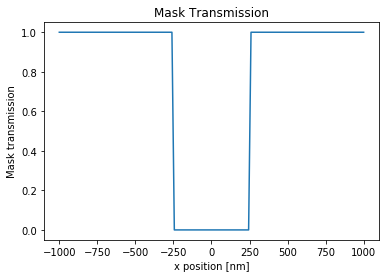

In [222]:
# Define the chromium dot size in nanometers
dot_size=500.
# Define the mask support (x support)
# Since we compute FT, better to chose a 2^n number of points
x_support=np.linspace(-1000.,1000.,128)
# Compute the pixel size in nanometers
dx=2000./128
# Define the mask, 1 for glass, 0 for chromium
mask=[0 if np.abs(x)<dot_size/2 else 1 for x in x_support]
# Plot
plt.title('Mask Transmission')
plt.plot(x_support, mask)
plt.xlabel('x position [nm]')
plt.ylabel('Mask transmission')

From there we compute **the Fourier Transform** of the mask.  
With numeric Fourier Transform one has to use the shift function to recenter the low frequency at the center for both spectrum and support.

Text(0, 0.5, 'Mask spectrum')

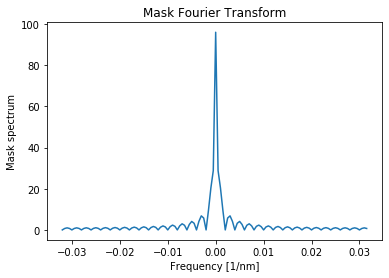

In [223]:
# Computation of the mask TF and its frequency support
mask_ft=np.fft.fftshift(np.fft.fft(mask))
freq_support=np.fft.fftshift(np.fft.fftfreq(128,d=dx))
# Plotting section
plt.title('Mask Fourier Transform')
plt.plot(freq_support,np.abs(mask_ft))
plt.xlabel('Frequency [1/nm]')
plt.ylabel('Mask spectrum')

## Source definition

The sources (S) illuminates the mask (M) at different angles of incidence depending on its shape.
In lithography the source is imaged by a collection lens (Lc0) at the entrance pupil (P1) of a another lens (L1). The optical configuration used is called Köhler illumination and it is illustrated on the Figure below. This configuration ensure that a source point creates a plane wave illuminating the mask at a specific angle relative to the optical axis.

The source point on the optical axis (green point) creates a plane wave parallel to the optical axis. As the source points moves further from the optical axis the angle of the plane wave incident on the mask increases.

<img src="img/kohler.png" width=500 height=60 />
<h3><center>Köhler illumination principle : illumination of the mask</center></h3>

- **S**: source
- **Lc0**: collection lens 0
- **P1**: entrance pupil of L1
- **L1**: lens 1
- **M**: mask plane

Different shapes of source exist, the most simple one is the circular source, defined by its radius $\sigma$ that corresponds to the source **coherence**.
The source coherence in lithography shouldn't be mistaken with the general meaning of coherence in optics. In lithography all source points are considered to be incoherent : they do not have phase relationship with each other. This consideration is the starting point of the Abbe theory : the overall image is the incoherent sum of each source point contribution.

Depending on the $\sigma$ value the source is said to be:
- Coherent if $\sigma=0$ : there is only one source point that is coherent with itself.
- Incoherent if $\sigma=\inf$ : infinity of source points
- Partially coherent if $0<\sigma<\inf$

In pratice all sources used in lithography are partially coherent. But many textbooks use a coherent source to present fundamental properties of imaging before moving to partially coherent source.

If we consider a circular source of coherence $\sigma$ the image of the source through the optical system is also circular, it is a circle of radius $\frac{\sigma NA}{\lambda}$.

<font color=red> The image of the source at the entrance pupil of the projection lens is called **the effective source**. It is not the Fourier Transform of the source ! It is an image of the source that is projected on the same plane as the mask spectrum. Thus it is convenient to express it on a frequency support.</font>

The Figure below continues the ray tracing of the previous Figure in absence of a mask. The effective source is located at the P2 plane.

<img src="img/kohler_full.png" width=750 height=60 />
<h3><center>Köhler illumination principle : source effective at P2</center></h3>

- **Lc1**: collection lens 1
- **P2** : entrance pupil of L2, of radius NA
- **L2** : projection lens

At this point we have all the source points that contribute to the formation of the aerial image.
As the effetive source is expressed in frequency domain there is a correspondance between the source point position in real space (S), the source point in the entrance pupil plane (P1) and the angle of incidence of the ray on the mask.
$$f=\frac{\sin(\theta)}{\lambda}$$

*References*

- [Köhler, A. (1893). Ein neues Beleuchtungsverfahren für mikrophotographische Zwecke. Zeitschrift für wissenschaftliche Mikroskopie und für Mikroskopische Technik, 10(4), 433-440.](https://archive.org/details/cbarchive_41715_einneuesbeleuchtungsverfahrenf1893)

## Projection lens definition

The projection lens, as its name implies, projects the image of the mask on the substrate.
From a Fourier Optics point of view, it catches a portion of the mask Fourier Transform and projects the Inverse Fourier Transform of this portion on the wafer.

The projection lens acts as a low pass filter for the mask Fourier Transform.
Low frequency can go trough the lens and get recombined before being projected on the substrate.
However for large frequencies the signal is lost.

This frequency behavior is controlled by the projection lens numerical aperture : NA.
Mathematically the effect of the projection lens is described as a circular transfert function as follows:
$$\tilde{H}(f,g)=\text{circ}\left(\frac{\sqrt{f^2+g^2}}{\frac{\text{NA}}{\lambda}}\right) $$


## Numeric implementation for Abbe method

The algorithm corresponding to the Abbe method for aerial image is constructed as follow


1. Computation of the effective source based on the frequency support of the mask Fourier Transform.
2. Loop over all effective source point (reminder : each source point is a frequency).
3. For current source point a shifted freuqency support is computed.
4. The shifted frequency support is used to create the shifted pupil of the projection lens (it is a binary mask in absence of aberrations).
5. The Fourier Transform of the mask is multiplied by this mask (it is a filtering operation in frequency space).
6. The contribution of the current source point is added to the overall aerial image.
7. Repeat step 3 to 6 for all source points.

The code for a 1D mask is described below:

In [224]:
def compute_abbe(sigma,NA,wavelength,mask_ft,frq,make_plots=False):
    # Define the effective source points of the circular source
    source_points=[f for f in frq if np.abs(f)<=sigma*NA/wavelength]
    # Initialisation of the aerial image as single precision
    aerial_image=np.zeros_like(mask_ft,dtype='float32')
    # Compute all source points contribution to the aerial image
    for freq_src in source_points:
        # Shift of the frequency support relative to the source point frequency
        freq_msk_shft = [(f - freq_src) for f in frq]
        # Shift of the projection lens pupil
        pupil_shifted = [1 if np.abs(f) <= NA/wavelength else 0 for f in freq_msk_shft]
        # The pupil applies a low pass filtre to the mask spectrum
        mask_lpf = np.multiply(mask_ft, pupil_shifted)
        # Add the contribution of the current src point to the overall aerial image
        aerial_image += np.abs(np.fft.ifft(mask_lpf)) ** 2
    # Normalisation with number of source points
    aerial_image /= len(source_points)
    
    if make_plots:
        # Plotting 
        fig=plt.figure()
        plt.title(f'Aerial Image - {len(source_points)} source points')
        plt.plot(x_support,aerial_image)
        plt.xlabel('x position [nm]')
        plt.ylabel('Intensity [au]')
    else:
        return aerial_image

The Figure below let you change different parameters to see the impact on the aerial image.<br>
<font color=red> **Unfortunately interactive widget do no run on GitHub please download and run the Jupyter File on your loac machine to use this feature.**</font>

In [225]:
#Uncomment to use interactive mode
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
#interact(compute_abbe, sigma=(0.0,1.0,0.01),NA=(0.2,0.6,0.01), wavelength=[('436nm', 436), ('365nm', 365),('248nm', 248), ('193nm', 193)],mask_ft=fixed(mask_ft),frq=fixed(freq_support),make_plots=fixed(True));

In case interactive plot does not show, we plot below the result for an i-line stepper.

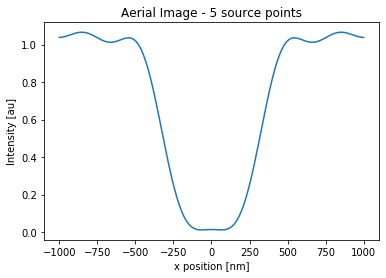

In [226]:
compute_abbe(sigma=0.7,NA=0.57,wavelength=365.,mask_ft=mask_ft,frq=freq_support,make_plots=True)

Another common benchmark is to compute the aerial image of a knife edge also called Heavyside function.

Text(0, 0.5, 'Amplitude')

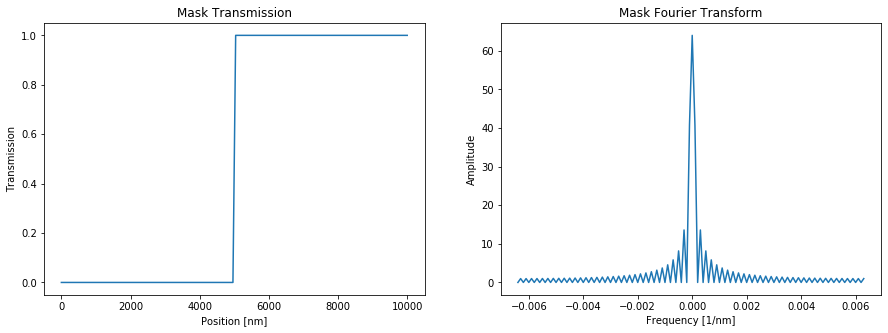

In [227]:
# Heavyside mask creation
n_pts=128
x_suppt_heavyside=np.linspace(0,10000.,n_pts)
mask_heavyside=[1 if x>=5000 else 0 for x in x_suppt_heavyside]
# Pixel size in nanometers
dx_heavyside=10000./n_pts
# Computation of the mask TF and its frequency support
mask_ft_heavyside=np.fft.fftshift(np.fft.fft(mask_heavyside))
freq_support_heavyside=np.fft.fftshift(np.fft.fftfreq(n_pts,d=dx_heavyside))
# Plotting section
fif,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Mask Transmission')
ax[0].plot(x_suppt_heavyside,mask_heavyside)
ax[0].set_xlabel('Position [nm]')
ax[0].set_ylabel('Transmission')
# FT plot
ax[1].set_title('Mask Fourier Transform')
ax[1].plot(freq_support_heavyside,np.abs(mask_ft_heavyside))
ax[1].set_xlabel('Frequency [1/nm]')
ax[1].set_ylabel('Amplitude')

Let's compute the aerial image for different source coherence to show the impact of this parameter:

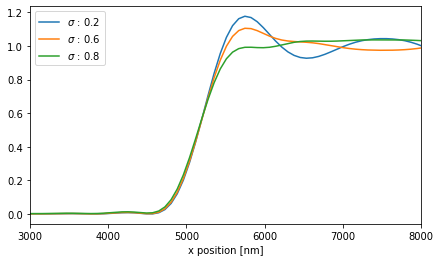

In [228]:
plt.figure(figsize=(7,4))
# Loop over different coherence values
for sigma in [0.2, 0.6, 0.8]:
    aerial_image_heavyside=compute_abbe(sigma=sigma,NA=0.28,wavelength=436.,mask_ft=mask_ft_heavyside,frq=freq_support_heavyside)
    plt.plot(x_suppt_heavyside,aerial_image_heavyside,label=f'$\sigma$ : {sigma}')
plt.xlim(3000.,8000.)
plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.legend()


We can compare our model result with the plot of the original article:

- [O'Toole, M. M., & Neureuther, A. R. (1979). *Influence of partial coherence on projection printing. In Developments in Semiconductor Microlithography IV* (Vol. 174, pp. 22-27). International Society for Optics and Photonics.](https://spie.org/Publications/Proceedings/Paper/10.1117/12.957174)


<img src="img/neureuther_coherence_heavyside.PNG" width=500 height=60 />

## Numeric implementation for Hopkins method
<font color=red> **Make sure that the support for the mask definition is strictly positive for hopkins formulation**</font>

The algorithm corresponding to the Hopkins method for aerial image is constructed as follow
1. The first step is to compute the TCC coefficients.
2. For all pre compute TCC compute the equation of Hopkins equation
3. Normalise aerial image with aerial image for a clear mask (only quartz)

In [229]:
# Initialisation of the TCC list
tcc_list=[]
def tcc_computation(sigma, NA, wavelength, freqs):
    # Cutoff frequencies 
    f_cut_src = sigma * NA / wavelength
    f_cut_pupil = NA / wavelength
    # Source creation
    y_src = [1 if np.abs(f) <= f_cut_src else 0 for f in freqs]
    # k factor definition
    k = 2 * np.pi / wavelength
    # Loop over diffractions orders for the first pupil
    for idx_m, f_m in enumerate(freqs):
        # The first pupil is created via a shifted frequency support
        freq_pup_1 = [f - f_m for f in freqs]
        y_pup1 = [1 if np.abs(f) <= f_cut_pupil else 0 for f in freq_pup_1]
        # Loop over diffractions orders for the second pupil
        for idx_n, f_n in enumerate(freqs):
            # The second pupil is also created via a shifted frequency support
            freq_pup_2 = [f - f_n for f in freqs]
            y_pup2 = [1 if np.abs(f) <= f_cut_pupil else 0 for f in freq_pup_2]
            # Integral computation of the overlapping three functions
            product = np.multiply(y_src, np.multiply(y_pup1, y_pup2))
            #The overlapping area is computed with a trapezoidal integration
            area = np.trapz(product, freqs)
            # If the TCC coefficient is non zero it is added to the TCC list
            if np.abs(area) > 0:
                tcc_list.append((idx_m, idx_n, f_m, f_n, area))

    print('Number of TCC :', len(tcc_list))

In [230]:
tcc_computation(0.4, 0.28, 436.,freq_support_heavyside)

Number of TCC : 269


Once the TCC are calculated the Hopkins implementation is straightforward:

In [231]:
def compute_hopkins(mask_ft, freq_suppt, x_suppt, tcc_list, pixel_size):
        # Compute the mask Fourier transform conjugate
        mask_ft_conj = np.conjugate(mask_ft)
        # Instanciate aerial image
        aerial_image = np.zeros_like(mask_ft)
        # Loop over all TCC coefficients
        for idx_m, idx_n, f_m, f_n, tcc_mn in tcc_list:
            exp_term = np.exp(1j * 2 * np.pi * (f_m - f_n) * (x_suppt-pixel_size/2))
            aerial_image += tcc_mn * mask_ft[idx_m] * mask_ft_conj[idx_n] * exp_term
        return np.real(aerial_image)

We propose to compute the aerial image of the Heavyside mask that has already be defined previously.

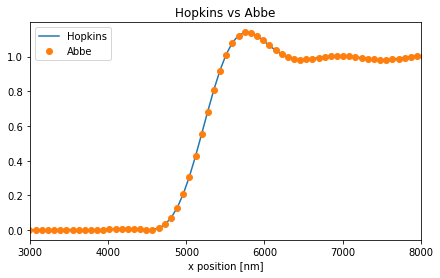

In [232]:
#First we compute the aerial image of a clear mask
mask_quartz=np.ones_like(mask_ft_heavyside)
aerial_image_norm=compute_hopkins(mask_ft=np.fft.fftshift(np.fft.fft(mask_quartz)),
                                  freq_suppt=freq_support_heavyside,
                             x_suppt=x_suppt_heavyside,
                             tcc_list=tcc_list,pixel_size=dx_heavyside)
#Compute aerial image of the heavyside mask
aerial_image_hopkins=compute_hopkins(mask_ft=mask_ft_heavyside, freq_suppt=freq_support_heavyside,x_suppt=x_suppt_heavyside, tcc_list=tcc_list,pixel_size=dx_heavyside)
#Recompute aerial image with Abbe to compare both models
aerial_image_abbe=compute_abbe(sigma=0.4,NA=0.28,wavelength=436.,mask_ft=mask_ft_heavyside,frq=freq_support_heavyside)
# Plot Hopkins and Abbe aerial image on same plot
plt.figure(figsize=(7,4))
plt.title('Hopkins vs Abbe')
plt.plot(x_suppt_heavyside,aerial_image_hopkins/aerial_image_norm,label='Hopkins')
plt.plot(x_suppt_heavyside,aerial_image_abbe,'o',label='Abbe')
plt.xlim(3000.,8000.)
plt.xlabel('Intensity')
plt.xlabel('x position [nm]')
plt.legend()

In [233]:
# Code to automatically center the matplotlib figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")